# Import modules

This script makes simplified Köppen classifications for CESM input data.
It is assumed that the raw input data is in a folder called "data" with subfolders Control, SAI 2020 and SAI 2080.
The Köppen classes are saved as .nc files.

You can select the scenario and years over which to produce the Köppen class somewhere below. 
Unfortunately, you may need to restart the kernel and delete all previous cell output in order to switch from one scenario or time range to another, because otherwise the script won't update the output. 

In [1]:
import sys

sys.path.insert(0, "/home/fiona/") #change path to where the script is running. 
import cesm_scenarios
import geo_tools
import variables

# geo-data handling
import xarray as xr
from pathos.multiprocessing import ProcessingPool as Pool

# standard numerical package
import numpy as np
import math

# visualization
import matplotlib.pyplot as plt
from matplotlib import colorbar
from matplotlib.colors import LinearSegmentedColormap
from matplotlib import cm
import multiprocessing

import warnings
warnings.filterwarnings('ignore')

/gpfs/home4/cwieners/fiona/cesm_scenarios.py:17: FutureWarning: xarray subclass Equidistant_Lon_Lat_Field should explicitly define __slots__
  class Equidistant_Lon_Lat_Field(xr.DataArray):


In [2]:
import importlib
importlib.reload(geo_tools)
importlib.reload(variables)

<module 'variables' from '/gpfs/home4/cwieners/fiona/variables.py'>

# Load data

### Temperature

In [3]:
T_cnt_files = ['b.e21.BSSP585cmip6.f09_g17.control.01.cam.h0.TREFHT.201501-206412.nc',
            'b.e21.BSSP585cmip6.f09_g17.control.01.cam.h0.TREFHT.206501-209912.nc']

# Due to an error that occured during the simulation, 
# the years 2045-2050 are faulty in the first run.
# I will manually crop them
T_sai2020_files = ['b.e21.BSSP585cmip6.f09_g17.2020feedback.01.cam.h0.TREFHT.202001-202912.nc',
                'b.e21.BSSP585cmip6.f09_g17.2020feedback.01.cam.h0.TREFHT.203001-203912.nc',
                'b.e21.BSSP585cmip6.f09_g17.2020feedback.01.cam.h0.TREFHT.204001-204912.nc',
                'b.e21.BSSP585cmip6.f09_g17.2020feedback.02.cam.h0.TREFHT.204501-209412.nc',
                'b.e21.BSSP585cmip6.f09_g17.2020feedback.02.cam.h0.TREFHT.209501-209912.nc']

T_sai2080_files = ['b.e21.BSSP585cmip6.f09_g17.feedback.05.cam.h0.TREFHT.208001-208512.nc',
                'b.e21.BSSP585cmip6.f09_g17.feedback.06.cam.h0.TREFHT.208601-209912.nc']

files = {
    'Control': T_cnt_files,
    'SAI 2020': T_sai2020_files,
    'SAI 2080': T_sai2080_files
}

In [4]:
# I will save the temperature data in dictionaries indexed by the scenario name
scenarios = ['Control', 'SAI 2020', 'SAI 2080']
T1 = {}

for scenario in scenarios:
    # collect all partial datasets
    da_container = []
    for file_name in files[scenario]:
        path = f"./data/{scenario}/{file_name}"
        # handle the special case of SAI2020
        if (scenario == 'SAI 2020') and (file_name == T_sai2020_files[2]):
            da_container.append(xr.open_dataset(path).TREFHT.sel(time=slice('2040','2044')))
        else:
            da_container.append(xr.open_dataset(path).TREFHT)
    # concatenate the dataset
    T1[scenario] = xr.concat(da_container,dim='time')

In [5]:
T = {'Control': T1['Control'].sel(time = slice('2020', '2099')) - 273.15,
     'SAI 2020': T1['SAI 2020'].sel(time = slice('2020', '2099')) - 273.15, # time: 957 (missing 2020-1-1)
     'SAI 2080': xr.concat((T1['Control'].sel(time = slice('2020', '2079')), T1['SAI 2080'].sel(time = slice('2080', '2099'))), dim = 'time') - 273.15}

In [57]:
lat=T['Control'].lat
lon=T['Control'].lon

### Precipitation

In [6]:
PRECC_cnt_files = ['b.e21.BSSP585cmip6.f09_g17.control.01.cam.h0.PRECC.201501-206412.nc',
                   'b.e21.BSSP585cmip6.f09_g17.control.01.cam.h0.PRECC.206501-209912.nc']

PRECL_cnt_files = ['b.e21.BSSP585cmip6.f09_g17.control.01.cam.h0.PRECL.201501-206412.nc',
                   'b.e21.BSSP585cmip6.f09_g17.control.01.cam.h0.PRECL.206501-209912.nc']

# Due to an error that occured during the simulation, 
# the years 2045-2050 are faulty in the first run.
# I will manually crop them
PRECC_sai2020_files = ['b.e21.BSSP585cmip6.f09_g17.2020feedback.01.cam.h0.PRECC.202001-202912.nc',
                       'b.e21.BSSP585cmip6.f09_g17.2020feedback.01.cam.h0.PRECC.203001-203912.nc',
                       'b.e21.BSSP585cmip6.f09_g17.2020feedback.01.cam.h0.PRECC.204001-204912.nc',
                       'b.e21.BSSP585cmip6.f09_g17.2020feedback.02.cam.h0.PRECC.204501-209412.nc 7.18.08',
                       'b.e21.BSSP585cmip6.f09_g17.2020feedback.02.cam.h0.PRECC.209501-209912.nc']

PRECL_sai2020_files = ['b.e21.BSSP585cmip6.f09_g17.2020feedback.01.cam.h0.PRECL.202001-202912.nc',
                       'b.e21.BSSP585cmip6.f09_g17.2020feedback.01.cam.h0.PRECL.203001-203912.nc',
                       'b.e21.BSSP585cmip6.f09_g17.2020feedback.01.cam.h0.PRECL.204001-204912.nc',
                       'b.e21.BSSP585cmip6.f09_g17.2020feedback.02.cam.h0.PRECL.204501-209412.nc',
                       'b.e21.BSSP585cmip6.f09_g17.2020feedback.02.cam.h0.PRECL.209501-209912.nc']

PRECC_sai2080_files = ['b.e21.BSSP585cmip6.f09_g17.feedback.09.cam.h0.PRECC.208001-209912.nc']

PRECL_sai2080_files = ['b.e21.BSSP585cmip6.f09_g17.feedback.09.cam.h0.PRECL.208001-209912.nc']

files_PRECC = {
    'Control': PRECC_cnt_files,
    'SAI 2020': PRECC_sai2020_files,
    'SAI 2080': PRECC_sai2080_files
}

files_PRECL = {
    'Control': PRECL_cnt_files,
    'SAI 2020': PRECL_sai2020_files,
    'SAI 2080': PRECL_sai2080_files
}

In [7]:
scenarios = ['Control', 'SAI 2020', 'SAI 2080']
PRECC1 = {}
PRECL1 = {}

for scenario in scenarios:
    # collect all partial datasets
    da_container = []
    for file_name in files_PRECC[scenario]:
        path = f"./data/{scenario}/{file_name}"
        # handle the special case of SAI2020
        if (scenario == 'SAI 2020') and (file_name == PRECC_sai2020_files[2]):
            da_container.append(xr.open_dataset(path,engine='netcdf4').PRECC.sel(time=slice('2040','2044')))
        else:
            da_container.append(xr.open_dataset(path,engine='netcdf4').PRECC)
    # concatenate the dataset
    PRECC1[scenario] = xr.concat(da_container,dim='time')
    
for scenario in scenarios:
    da_container = []
    for file_name in files_PRECL[scenario]:
        path = f"./data/{scenario}/{file_name}"
        # handle the special case of SAI2020
        if (scenario == 'SAI 2020') and (file_name == PRECL_sai2020_files[2]):
            da_container.append(xr.open_dataset(path).PRECL.sel(time=slice('2040','2044')))
        else:
            da_container.append(xr.open_dataset(path).PRECL)
    # concatenate the dataset
    PRECL1[scenario] = xr.concat(da_container,dim='time')

In [8]:
prect = {'Control': (PRECC1['Control'] + PRECL1['Control']).sel(time = slice('2020', '2099')),
         'SAI 2020': (PRECC1['SAI 2020'] + PRECL1['SAI 2020']).sel(time = slice('2020', '2099')),
         'SAI 2080': xr.concat(
             ((PRECC1['Control'] + PRECL1['Control']).sel(time = slice('2020', '2079')),
             (PRECC1['SAI 2080'] + PRECL1['SAI 2080']).sel(time = slice('2080', '2099'))),
             dim = 'time') }

In [9]:
prect_m = { name: (prect[name]*1000*3600*24) for name in scenarios }

### Land mask

In [10]:
lm_files = ['b.e21.BSSP585cmip6.f09_g17.control.01.cam.h0.LANDFRAC.201501-206412.nc',
            'b.e21.BSSP585cmip6.f09_g17.control.01.cam.h0.LANDFRAC.206501-209912.nc']

files = {'Control': lm_files}

In [11]:
scenarios = ['Control']
lm1 = {}

for scenario in scenarios:
    # collect all partial datasets
    da_container = []
    for file_name in files[scenario]:
        path = f"./data/{scenario}/{file_name}"
        da_container.append(xr.open_dataset(path).LANDFRAC)
    # concatenate the dataset
    lm1[scenario] = xr.concat(da_container,dim='time')
    
# change 0 to nan
land_mask = lm1['Control'].where(lm1['Control'].data == 1, np.nan) 

# Functions

In [12]:
def monthly_mean_blocks(da, first_year, X, sim = 'control'):
    
    """
    Takes an xarray DataArray defined over a lat/lon field over time
    and calculates the monthly mean averaged every X years

    Parameters:
        da (DataArray): data array containing a field defined over latitudes (lat), longitudes (lon) and time
        first_year (integer): first year from which the average is calculated
        X (integer): number of years to calculate the mean over
        blocks: if False, only compute one block (from first_year onwards, X years); otherwise we generate more blocks as explained below.
        sim (string): or control or sai

    Returns:
        Array containing Data Array of the last X monthly mean
        Output (X = 10): years[0] = monthly mean of years 2020-2030
                         years[1] = monthly mean of years 2030-2040
                         etc
    """


#OLD VERSION
    
    assert sim in ['control', 'sai'], f'sim must be either control or sai and not {sim}'
    
    if sim == 'control':
        length = int((len(da)/ (12 * X)))
        
    elif sim == 'sai':
        length = int((len(da) / (12 * X))) + 1
        
    years = np.zeros(length, dtype = object)
    
    # select every X years
    for i in range(0, length):    
        years[i] = da.sel(time = slice(str(first_year + i*X), str(first_year + i*X + X))).groupby('time.month').mean(dim = 'time')
        
    return years


In [62]:
def monthly_mean(da, first_year, X, sim = 'control'):
    
    """
    Takes an xarray DataArray defined over a lat/lon field over time
    and calculates the monthly mean averaged every X years

    Parameters:
        da (DataArray): data array containing a field defined over latitudes (lat), longitudes (lon) and time
        first_year (integer): first year from which the average is calculated
        X (integer): number of years to calculate the mean over
        blocks: if False, only compute one block (from first_year onwards, X years); otherwise we generate more blocks as explained below.
        sim (string): or control or sai

    Returns:
        Array containing Data Array of the last X monthly mean
        Output (X = 10): years[0] = monthly mean of years 2020-2030
                         years[1] = monthly mean of years 2030-2040
                         etc
    """


    assert sim in ['control', 'sai'], f'sim must be either control or sai and not {sim}'

    '''
    if sim == 'control':
        length = int((len(da)/ (12 * X)))
        
    elif sim == 'sai':
        length = int((len(da) / (12 * X))) + 1
    '''
        
    years = da.sel(time = slice(str(first_year), str(first_year + X))).groupby('time.month').mean(dim = 'time')
    return years
    
    '''
#OLD VERSION
    
    assert sim in ['control', 'sai'], f'sim must be either control or sai and not {sim}'
    
    if sim == 'control':
        length = int((len(da)/ (12 * X)))
        
    elif sim == 'sai':
        length = int((len(da) / (12 * X))) + 1
        
    years = np.zeros(length, dtype = object)
    
    # select every X years
    for i in range(0, length):    
        years[i] = da.sel(time = slice(str(first_year + i*X), str(first_year + i*X + X))).groupby('time.month').mean(dim = 'time')
        
    return years
    '''

# Apply Köppen classification

_Note_: average over 20 years instead of 15

In [82]:
# prepare data

#first, pick the years of interest:
first_year=2085 #first year to pick
nr_year=15 #number of years used
scen='Control' #options: 'Control','SAI 2020','SAI 2080' (in the latter case, careful with start year...)

#T_month_mean = np.zeros(1, dtype = object)
#prect_month_mean = np.zeros(1, dtype = object)

if scen=='Control':
    print(scen, first_year)
    T_month_mean=monthly_mean(T[scen], first_year, nr_year, sim = 'control')
    prect_month_mean=monthly_mean(prect[scen], first_year, nr_year, sim = 'control')
else:
    print(scen, first_year)
    T_month_mean=monthly_mean(T[scen], first_year, nr_year, sim = 'sai')
    prect_month_mean=monthly_mean(prect[scen], first_year, nr_year, sim = 'control')

np.shape(T_month_mean)

Control 2085


(12, 192, 288)

Now we have made a lot of data over various 20-year blocks.
In the next cell we select a scenario and a block

In [83]:
# define variables

land_mask_new = land_mask.stack(pos = ('lat', 'lon')).transpose('pos', 'time').load()

""" have to change ts and pr for every simulation and for every time period (see cell above for more information) """
ts = T_month_mean.stack(pos = ('lat', 'lon')).transpose('pos', 'month').load() 
pr = prect_month_mean.stack(pos = ('lat', 'lon')).transpose('pos', 'month').load() 

print(np.min(ts))
print(np.max(ts))

<xarray.DataArray 'TREFHT' ()>
array(-56.06090164)
<xarray.DataArray 'TREFHT' ()>
array(48.08243561)


In [84]:
rows = 192
cols = 288

In [85]:
def koppen_beck(index: range) -> dict:
    
    """
    Applies the Köppen climate distribution to ts and pr
        ts and pr global: np.array w/ shape == (rows * cols, 12), not an argument to the function!
                          (time: 12 months)
    
    Parameters:
        index (integer): range iterable with the number of cells in the raster (rows * cols)
    
    Returns:
        Dictionary with the Köppen regions assigned to a number
    
    """
    
    # check if the region is ocean or land
    if land_mask_new[index].values.max() != 1:
        koppenClass = "ocean"
            
    else:
        # pre-calculations
        MAT = ts[index].mean() #.sum() / 12 # annual mean temperature over the considered region
        MAP = pr[index].sum() # total annual precipitation over the considered region
        Pdry = pr[index].min() # driest month of the considered region
        Tcold = ts[index].min() # coldest month of the considered region
        Thot = ts[index].max() # hottest month of the considered region
        Tmon10 = 0 # number of months where T > 10ºC

        for temp in ts[index]:
            if temp > 10:
                Tmon10 += 1
                
        if index < rows * cols / 2:  # southern hemisphere, aut+wint from the 3rd to 9th month
            he = "S"
            # check last condition for group B (if pr < 30% MAP spr+summ) but the other way around 
            if pr[index, 3:9].sum() > 0.7 * MAP:
                Pth = 2 * MAT             
            # check first condition for group B (if pr > 70% MAP spr+summ)
            elif np.concatenate((pr[index, 0:3], pr[index, 9:12])).sum() > 0.7 * MAP:
                Pth = 2 * MAT + 28                
            # if none of the above was true, apply second condition
            else:
                Pth = 2 * MAT + 14
                
            Pwdry = pr[index, 3:9].min() # min precipitation during aut+wint
            Pwwet = pr[index, 3:9].max() # max precipitation during aut+wint
            Psdry = np.concatenate((pr[index, 0:3], pr[index, 9:12])).min() # min precipitation during spr+summ
            Pswet = np.concatenate((pr[index, 0:3], pr[index, 9:12])).max() # max precipitation during spr+summ

        else:  # northern hemisphere, spr+summ from the 3rd to 9th month
            he = "N"
            # check conditions in the same order as before
            if np.concatenate((pr[index, 0:3], pr[index, 9:12])).sum() > 0.7 * MAP:
                Pth = 2 * MAT
            elif pr[index, 3:9].sum() > 0.7 * MAP:  # summer
                Pth = 2 * MAT + 28
            else:
                Pth = 2 * MAT + 14
            
            Psdry = pr[index, 3:9].min() # min precipitation during spr+summ
            Pswet = pr[index, 3:9].max() # max precipitation during spr+summ
            Pwdry = np.concatenate((pr[index, 0:3], pr[index, 9:12])).min() # min precipitation during aut+wint
            Pwwet = np.concatenate((pr[index, 0:3], pr[index, 9:12])).max() # max precipitation during aut+wint

        # classification conditionals
        if MAT >= 10 and MAP < 10 * Pth: # check MST and if PRECT exceeds the threshold
            koppenClass = "B"   
            # F: 2nd classification
            if MAP < 5 * Pth: # F: shouldn't this be 0.5? (50% = 0.5)
                koppenClass = koppenClass + "W"
            else:
                koppenClass = koppenClass + "S"
            # F: 3rd classification
            if Tcold < 0:
                koppenClass = koppenClass + 'k'
            else:
                koppenClass = koppenClass + "h"
            
            # ORIGINAL CODE
            # if MAT >= 18: 
            #    koppenClass = koppenClass + "h"

        elif Tcold >= 18:
            koppenClass = "A"
            # F: 2nd classification
            if Pdry >= 60:
                koppenClass = koppenClass + "f"
            else:
                if Pdry >= 100 - MAP / 25:
                    koppenClass = koppenClass + "m"
                else:
                    koppenClass = koppenClass + "w"

        elif Thot > 10 and 0 < Tcold < 18:
            koppenClass = "C"
            # F: 2nd classification
            if (Pwwet >= 3 * Psdry) and (Psdry < 40):
                koppenClass = koppenClass + "s"
            elif Pwdry < Pswet / 10:
                koppenClass = koppenClass + "w"
            else:
                koppenClass = koppenClass + "f"
            # F: 3rd classification
            if Thot >= 22:
                koppenClass = koppenClass + "a"
            else:
                if Tmon10 >= 4:
                    koppenClass = koppenClass + "b"
                elif 1 <= Tmon10 < 4:
                    koppenClass = koppenClass + "c"

        elif Thot > 10 and Tcold <= 0:
            koppenClass = "D"
            # F: 2nd classification
            if (Pwwet >= 3 * Psdry) and (Psdry < 30):
                koppenClass = koppenClass + "s"
            elif Pwdry < Pswet / 10:
                koppenClass = koppenClass + "w"
            else:
                koppenClass = koppenClass + "f"
            # F: 3rd classification
            if Thot >= 22:
                koppenClass = koppenClass + "a"
            else:
                if Tmon10 >= 4:
                    koppenClass = koppenClass + "b"
                elif Tcold < -38:
                    koppenClass = koppenClass + "d"
                else:
                    koppenClass = koppenClass + "c"

        elif Thot <= 10:
            koppenClass = "E"
            # F: 3rd classification
            if Thot > 0:
                koppenClass = koppenClass + "T"
            else:
                koppenClass = koppenClass + "F"

    koppenDict = {
        "ocean": -1,
        "Af": 1,
        "Am": 2,
        "Aw": 3,
        "BWh": 4,
        "BWk": 5,
        "BSh": 6,
        "BSk": 7,
        "Csa": 8,
        "Csb": 9,
        "Csc": 10,
        "Cwa": 11,
        "Cwb": 12,
        "Cwc": 13,
        "Cfa": 14,
        "Cfb": 15,
        "Cfc": 16,
        "Dsa": 17,
        "Dsb": 18,
        "Dsc": 19,
        "Dsd": 20,
        "Dwa": 21,
        "Dwb": 22,
        "Dwc": 23,
        "Dwd": 24,
        "Dfa": 25,
        "Dfb": 26,
        "Dfc": 27,
        "Dfd": 28,
        "ET": 29,
        "EF": 30
    }

    return koppenDict[koppenClass]

In [86]:
%%time

positions = np.arange(0, len(ts))
pool = Pool()
kb = pool.map(koppen_beck, positions)

CPU times: user 4.37 s, sys: 163 ms, total: 4.53 s
Wall time: 16.8 s


In [87]:
def new_biomes(koppen_list):
    
    """
    Reorganizes the Köppen groups into new biomes, based on dr. Gurevitch's suggestions
    
    Parameters:
        koppen_list (list): list with the Köppen group of every grid cell
    
    Returns:
        List with the new biomes per grid cell
    
    """
    
    biome_list = koppen_list.copy()
    
    for i in range(len(koppen_list)):
        if koppen_list[i] == 1:
            biome_list[i] = 1
        elif koppen_list[i] == 2:
            biome_list[i] = 2
        
        elif (koppen_list[i] == 21) or (koppen_list[i] == 22) or (koppen_list[i] == 25) or (koppen_list[i] == 26):
            biome_list[i] = 3
        elif (koppen_list[i] == 9) or (koppen_list[i] == 16):
            biome_list[i] = 4
        elif koppen_list[i] == 7:
            biome_list[i] = 5
        elif (koppen_list[i] == 14) or (koppen_list[i] == 15) or (koppen_list[i] == 11) :
            biome_list[i] = 6
        
        elif (koppen_list[i] == 3) or (koppen_list[i] == 6):
            biome_list[i] = 7
        elif (koppen_list[i] == 4) or (koppen_list[i] == 5):
            biome_list[i] = 8
        
        elif (koppen_list[i] == 8) or (koppen_list[i] == 10):
            biome_list[i] = 9
        elif (koppen_list[i] == 17) or (koppen_list[i] == 18):
            biome_list[i] = 10
       
        elif (koppen_list[i] == 19) or (koppen_list[i] == 20) or (koppen_list[i] == 12) or (koppen_list[i] == 13):
            biome_list[i] = 11
        elif (koppen_list[i] == 27) or (koppen_list[i] == 28):
            biome_list[i] = 12
        
        elif (koppen_list[i] == 23) or (koppen_list[i] == 24) or (koppen_list[i] == 29):
            biome_list[i] = 13
        elif koppen_list[i] == 30:
            biome_list[i] = 14
                
    return biome_list

In [88]:
new_biomes_list = new_biomes(kb)

# "new_biomes_list" is a list with the biome of every grid cell. This code needs to be run again for every different simulation.

In [89]:
ts

<xarray.DataArray 'TREFHT' (pos: 55296, month: 12)>
array([[-19.419262  , -17.91682   , -26.647253  , ..., -49.652664  ,
        -44.19591   , -31.333948  ],
       [-19.419275  , -17.916807  , -26.647253  , ..., -49.65266   ,
        -44.19591   , -31.33394   ],
       [-19.419218  , -17.916817  , -26.647257  , ..., -49.65266   ,
        -44.19591   , -31.333942  ],
       ...,
       [ -1.409666  ,  -3.2389567 ,  -6.65672   , ...,   1.9339375 ,
          0.67156166,  -0.22954305],
       [ -1.409615  ,  -3.2387533 ,  -6.655898  , ...,   1.9341085 ,
          0.6715108 ,  -0.22953288],
       [ -1.4095703 ,  -3.2385743 ,  -6.6551533 , ...,   1.9342468 ,
          0.671464  ,  -0.22953898]], dtype=float32)
Coordinates:
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
  * pos      (pos) MultiIndex
  - lat      (pos) float64 -90.0 -90.0 -90.0 -90.0 -90.0 ... 90.0 90.0 90.0 90.0
  - lon      (pos) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8

-1 30


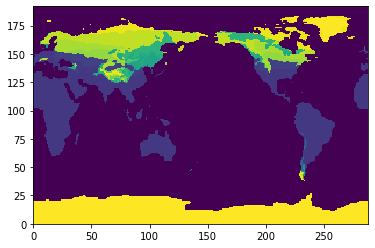

In [90]:
a_vec = np.array(kb, ndmin=2)
Koppensimple=a_vec.reshape((rows,cols))
np.shape(Koppensimple)

print(np.min(a_mat),np.max(a_mat))

%matplotlib inline
plt.pcolormesh(Koppensimple)

## Save file

In [92]:
scen

'Control'

In [91]:
#path = 'path/to/save/files/'

if scen=="SAI 2020":
    scenaux="SAI2020"
if scen=="SAI 2080":
    scenaux="SAI2080"
      
filename="./Koppen_" + scenaux + "_years_" + str(first_year) + "_to_" + str(first_year+nr_year) + ".nc"
print(filename)

./Koppen_SAI2020_years_2085_to_2100.nc


In [61]:
#da = xr.DataArray(new_biomes_list, dims=["index"])
Koppensimple = xr.DataArray(Koppensimple, dims=['lat','lon'],
                           coords={'lat': lat,
                                  'lon': lon},)


Koppensimple.to_netcdf(filename)

In [46]:
Koppensimple

<xarray.DataArray (lat: 192, lon: 288)>
array([[30, 30, 30, ..., 30, 30, 30],
       [30, 30, 30, ..., 30, 30, 30],
       [30, 30, 30, ..., 30, 30, 30],
       ...,
       [-1, -1, -1, ..., -1, -1, -1],
       [-1, -1, -1, ..., -1, -1, -1],
       [-1, -1, -1, ..., -1, -1, -1]])
Dimensions without coordinates: lat, lon